In [48]:
!pip install pyclipper

In [49]:
from tensorflow.keras.models import load_model, save_model
from keras.preprocessing import image
from tensorflow import lite
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

import chess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
input_img = cv2.imread('/content/drive/My Drive/Master_1/ComputerVision/chess/input.jpg')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(25, 25))  # width, height in inches
sub = fig.add_subplot(1,1,1)
sub.imshow(input_img, interpolation='nearest')

Output hidden; open in https://colab.research.google.com to view.

In order to detect the chess board and make the affine transformation to a top-down view of the full chess board we used the solution proposed by Maciej A. Czyzewski, Artur Laskowski and Szymon Wasik in "Chessboard and Chess Piece Recognition With the Support of Neural Networks"(2020).

Project github: https://github.com/maciejczyzewski/neural-chessboard

Paper: https://arxiv.org/pdf/1708.03898.pdf

As an overview: it uses a model trained to detect chessboard corners to detect all the corners in an image. It searches for all the corners that are on a line, makes a heatmap of those lines. Once it has an idea of where the board is because of those lines, it makes an affine transformation to "zoom in". It repeats this until it perfectly crops the board.


In [78]:
!python3 '/content/drive/My Drive/Master_1/ComputerVision/chess/boardDetection/main.py' detect --input='/content/drive/My Drive/Master_1/ComputerVision/chess/input.jpg' --output='/content/drive/My Drive/Master_1/ComputerVision/chess/board.jpg'

<<<  neural-chessboard  >>>
2021-05-24 20:23:46.394458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-24 20:23:48.469759: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-24 20:23:48.470938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-24 20:23:48.480992: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-24 20:23:48.481058: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (233b2b8461c5): /proc/driver/nvidia/version does not exist
2021-05-24 20:23:48.481592: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
mkdir: cannot create directory ‘test/steps’: No 

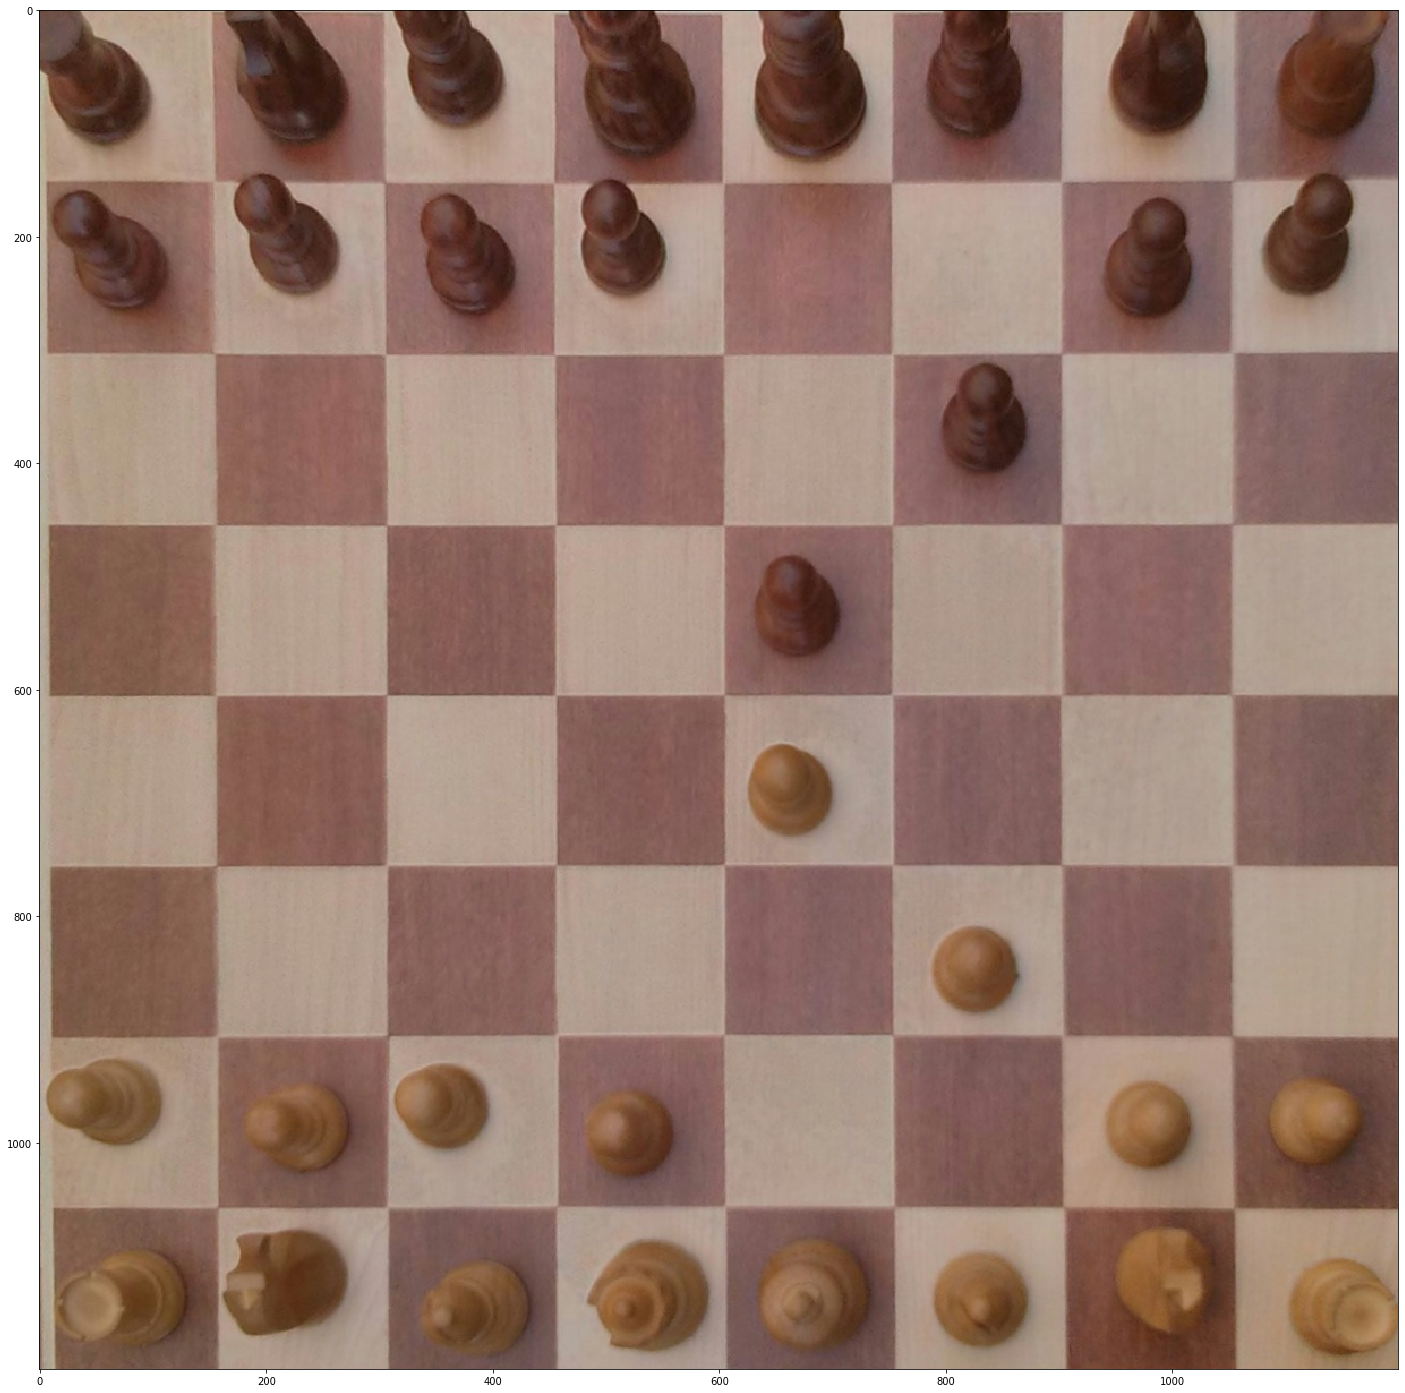

In [79]:
output_board = cv2.imread('/content/drive/My Drive/Master_1/ComputerVision/chess/board.jpg')
output_board = cv2.cvtColor(output_board, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(25, 25))  # width, height in inches
sub = fig.add_subplot(1,1,1)
sub.imshow(output_board, interpolation='nearest')

In [80]:
def separateIn64Squares(path):
  img = cv2.imread(path)
  squares = []
  for line in range(0, 8):
    for column in range(0, 8):
      squares.append(img[line * 150: line * 150 + 150, column * 150: column * 150 +150])
  
  i = 1
  for square in squares:
    cv2.imwrite("/content/drive/My Drive/Master_1/ComputerVision/chess/squares/" + str(i) + ".jpg", square)
    i+=1


separateIn64Squares('/content/drive/My Drive/Master_1/ComputerVision/chess/board.jpg')

In [81]:
# loading the InceptionResNetV2 model trained in "Chess piece detection Training.ipynb"
def get_model():
  return load_model('/content/drive/My Drive/Master_1/ComputerVision/chess/save_at_epoch_5_fine_tunned_prunned.h5', compile=False)

model = get_model()

In [82]:
def to_FEN_label(label_id):
  mapper = {
      0: "b",
      1: "k",
      2: "n",
      3: "p",
      4: "q",
      5: "r",
      6: "1",
      7: "B",
      8: "K",
      9: "N",
      10: "P",
      11: "Q",
      12: "R"
  }
  return mapper[label_id]

# array of 64 images of size 160 x 160 x 3(RGB)
# each image is a tile of the board
def to_FEN(images, facing='white'):
  images = np.array(images)
  classes = np.argmax(model.predict(images), axis=-1)
  classes = list(map(to_FEN_label, classes))
  classes_by_line = [classes[i:i+8] for i in range(0, len(classes), 8)]

  fen = ""

  if facing =='black':
    classes_by_line.reverse()
  for line in classes_by_line:
    emptys = 0
    fen_line = ""
    if facing =='black':
      line.reverse()
    for tile in line:
      if tile.isalpha():
        if emptys > 0:
          fen_line += str(emptys)
          emptys = 0
        fen_line += tile
      else:
        emptys += 1
      
    if emptys > 0:
      fen_line += str(emptys)
    fen_line += '/'
    fen += fen_line

  return fen[:-1] + ' w KQkq - 0 1'

def load_images_from_folder(folder):
    images = []
    for i in range(64):
        img = cv2.imread(os.path.join(folder, str(i + 1) + ".jpg"))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [83]:
images64 = load_images_from_folder('/content/drive/My Drive/Master_1/ComputerVision/chess/squares')

fig = plt.figure(figsize=(50, 50))  # width, height in inches
for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.imshow(images64[i], interpolation='nearest')

Output hidden; open in https://colab.research.google.com to view.

rnbqkbnp/pppp2pp/5p2/4p3/4P3/5P2/PPPP2Pp/RNpBKBNR w KQkq - 0 1


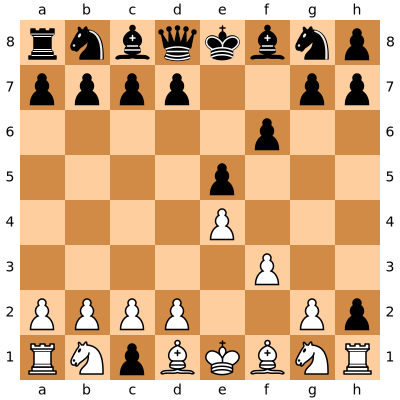

In [84]:
fen = to_FEN(images64)
print(fen)
chess.Board(fen)

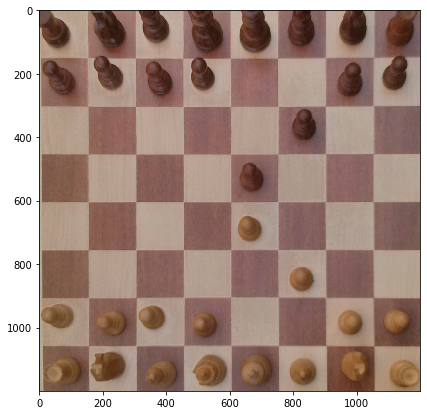

In [85]:
output_board = cv2.imread('/content/drive/My Drive/Master_1/ComputerVision/chess/board.jpg')
output_board = cv2.cvtColor(output_board, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(7, 7))  # width, height in inches
sub = fig.add_subplot(1,1,1)
sub.imshow(output_board, interpolation='nearest')